In [1]:
import os
os.chdir("..")

import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

from data.dataloader import dataloader_info
from utils.utils import load_yaml_config, instantiate_from_config

from models.predictor import GRU
from models.solver import Trainer
from data.dataloader import dataloader_info
from utils.visualize import visualize_pca, visualize_tsne, visualize_kernel
from models.solver import train_prediction_model, evaluate_model

/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load configurations
configs = load_yaml_config("configs/stock_adv.yaml")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize Diffusion_TS Model
diffusion_ts = instantiate_from_config(configs['gen_model']).to(device)
batch_size = 128

In [3]:
# dataloader
dl_info = dataloader_info(configs)
dataset = dl_info['dataset']

In [4]:
# load pretrained model
# try:
#     diffusion_ts.load_state_dict(torch.load("check_points/stock/gen_24/model_5000.pth"))
    
# except:
#     trainer = Trainer(config_solver=configs["gen_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
#     trainer.train_decomp()

In [5]:
# generate multivariate time-series
# fake_data = diffusion_ts.generate_mts(batch_size=3000)
# np.save(os.path.join(dataset.dir, f'ddpm_fake_stock.npy'), fake_data)

In [6]:
# load original data
seq_length, feature_dim = dataset.window, dataset.feature_dim
ori_data = np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"))
idx = np.random.permutation(len(ori_data))[:3000]
ori_data = ori_data[idx]

# load fake data
fake_data = np.load(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"))


In [7]:
# # PCA Analysis
# visualize_pca(ori_data, fake_data, n_sample=3000)
# visualize_tsne(ori_data, fake_data, n_sample=3000)
# visualize_kernel(ori_data, fake_data, n_sample=3000)

In [8]:
# ori_dl = dl_from_numpy(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_train.npy"), batch_size=batch_size)
# fake_dl = dl_from_numpy(os.path.join(dataset.dir, f"ddpm_fake_stock.npy"), batch_size=batch_size)

In [9]:
test_data_norm = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_data_{seq_length}_test.npy"))).to(device)
test_mean = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_mean_{seq_length}_test.npy"))).to(device)
test_std = torch.from_numpy(np.load(os.path.join(dataset.dir, f"stock_ground_truth_std_{seq_length}_test.npy"))).to(device)

from torch.utils.data import DataLoader, TensorDataset
test_dataset = TensorDataset(test_data_norm, test_mean, test_std)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
combiend_loss: 0.286696 l1_loss : 0.370075 fourier_loss : 0.096118 adv_loss : 0.039991: 100%|██████████| 1000/1000 [00:58<00:00, 17.01it/s]
reverse step from x_T to x_0:   0%|          | 0/500 [00:00<?, ?it/s]/home/harim/Desktop/pyproject/Project_TS_Generation/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered intern

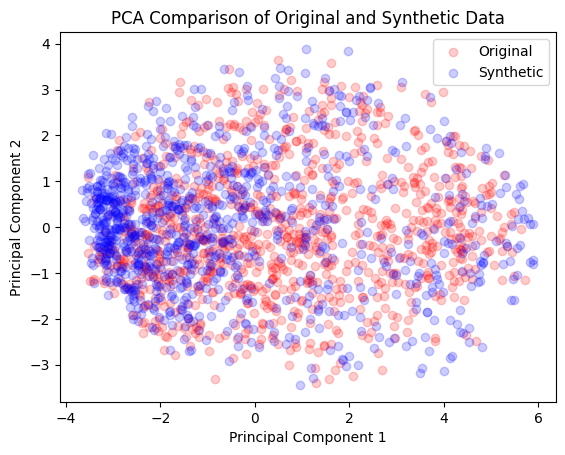

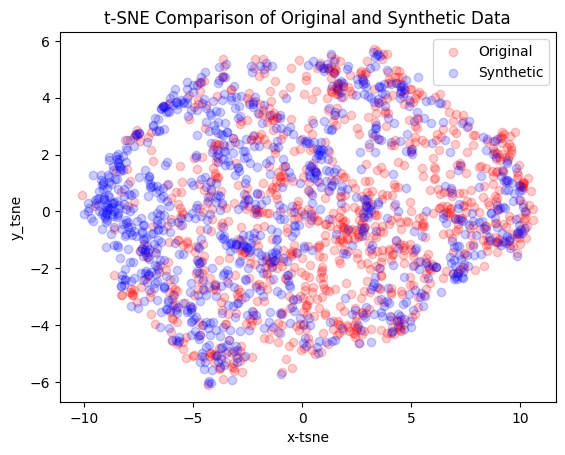

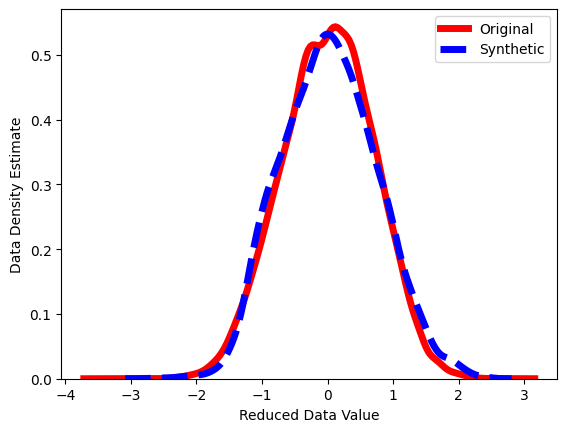

adversarial loss: 0.029753: 100%|██████████| 2000/2000 [01:00<00:00, 33.07it/s]


Adv Model : 	 L1 loss: 0.76175 	 L2 Loss : 0.99073 	 MAPE loss : 0.02218 


combiend_loss: 0.305537 l1_loss : 0.348598 fourier_loss : 0.093225 adv_loss : 0.038171:   2%|▏         | 21/1000 [00:01<00:53, 18.38it/s]

In [10]:
# Initialize adversarial Model
diffusion_ts = instantiate_from_config(configs['adv_model']).to(device)
diffusion_ts.train_predictor(dl_info["dataloader"], device, num_epochs=2000)

try:
    diffusion_ts.load_state_dict(torch.load("check_points/stock/gen_24/model_5000.pth"))
    
except:
    trainer = Trainer(config_solver=configs["gen_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
    trainer.train_decomp()

trainer = Trainer(config_solver=configs["adv_solver"], model=diffusion_ts, dataloader=dl_info["dataloader"])
for i in range(5):
    diffusion_ts.train()
    trainer.train_decomp()
    adv_data = diffusion_ts.generate_mts(batch_size=3000)
    np.save(os.path.join(dataset.dir, f'ddpm_adv_stock_{i}.npy'), adv_data)

    # visualize
    visualize_pca(ori_data, adv_data, n_sample=3000)
    visualize_tsne(ori_data, adv_data, n_sample=3000)
    visualize_kernel(ori_data, adv_data, n_sample=3000)
    
    ori_adv_data = np.concatenate([dataset.data, adv_data])
    ori_adv_data = torch.from_numpy(ori_adv_data).to(device)
    ori_adv_dl = DataLoader(ori_adv_data, batch_size=batch_size)
    train_prediction_model(diffusion_ts.predictor, 
                           ori_adv_dl, 
                           diffusion_ts.predictor_lossfn, 
                           diffusion_ts.predictor_optimizer, 
                           device=device, 
                           epochs=2000, 
                           description="adversarial")
    adv_l1, adv_l2, mape_adv, pred_y_adv, _ = evaluate_model(diffusion_ts.predictor, test_loader, device)
    print(f"Adv Model : \t L1 loss: {adv_l1:0.5f} \t L2 Loss : {adv_l2:0.5f} \t MAPE loss : {mape_adv:0.5f} ")

    
    